# Concept of feature importance

Feature importance can help us to have a better understanding of the features in the model, such that how important the features are to our model. This would increase the transparency (compared to black box) to those complicated machine learning models (by comparing to simple linear regression model, which can be easily visualized and intuitive to understand).



## basics of feature importance

In tree-based models, such as random forest model in sklearn library, feature importance is calculated by measuring the amount of impurity in the samples of a node and comparing it to the impurity of its child nodes after splitting on the feature. Since the goal of splitting on a feature is to reduce the impurity of the set of samples, if a feature can reduce the impurity of each subsamples, after splitting, this is a measure of how important that feature is in the decision-making of the model.

# 1. sklearn feature importance

Sklearn uses gini impurity to calcualte a measure of impurity for each node. Gini impurity, like entropy is a way to measure how "dis-organized" the observations are before and after splitting them using a feature. So, there is an impurity measure for each node.

### 1. impurity-based feature importance

This is what the sklearn documented (https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier): the impurity-based feature importances.  


### 2. permutation importance

Their comparison: https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance.html#sphx-glr-auto-examples-inspection-plot-permutation-importance-py

In general, the permutation importance can get more valid results from impurity-based feature importance.

### (1) Load library

In [30]:
###addint the graphviz path to executable path
# import os
# os.environ["PATH"] += os.pathsep + 'C:/Users/jenny.yang/OneDrive - Shell/Documents/graphviz-2-38/bin/'

In [19]:
# import sys
# !{sys.executable} -m pip install graphviz==0.9

In [1]:
from collections import defaultdict

import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import spearmanr
from scipy.cluster import hierarchy

from sklearn.datasets import load_breast_cancer
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split
import sklearn
from sklearn import tree
import graphviz
import seaborn as sns
import pandas as pd

C:\Users\jenny.yang\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### (2) Load data

In [2]:
data = load_breast_cancer()
X, y = data.data, data.target
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [3]:
print("Total feature number=", len(data.feature_names))
data.feature_names

Total feature number= 30


array(['mean radius', 'mean texture', 'mean perimeter', 'mean area',
       'mean smoothness', 'mean compactness', 'mean concavity',
       'mean concave points', 'mean symmetry', 'mean fractal dimension',
       'radius error', 'texture error', 'perimeter error', 'area error',
       'smoothness error', 'compactness error', 'concavity error',
       'concave points error', 'symmetry error',
       'fractal dimension error', 'worst radius', 'worst texture',
       'worst perimeter', 'worst area', 'worst smoothness',
       'worst compactness', 'worst concavity', 'worst concave points',
       'worst symmetry', 'worst fractal dimension'], dtype='<U23')

In [43]:
feature_df = pd.DataFrame( {"name" : data.feature_names, "id": list(range(X.shape[1]))})

#### data has multi-colinearity problem

In [48]:
corr = spearmanr(X).correlation

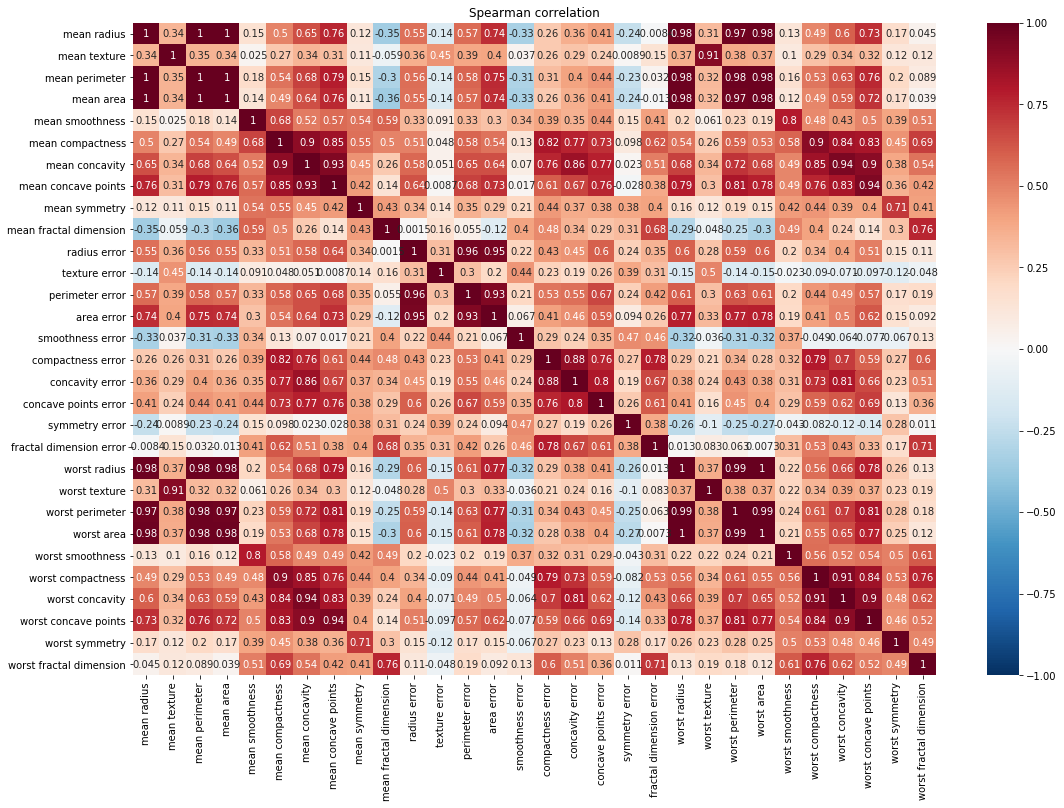

In [59]:
plt.figure(figsize = (18, 12))
ax = sns.heatmap(corr, annot=True, vmin = -1, vmax = 1, center = 0, cmap = "RdBu_r", xticklabels = data.feature_names, yticklabels = data.feature_names )
ax.set_title('Spearman correlation')
plt.show()

### (3) Different model type

Here, we will first compare the decision tree and random forest's performance.

### (3.1) decision tree model

In [4]:
##Train a decision tree
tmodel = tree.DecisionTreeClassifier(random_state = 0)
tmodel.fit(X_train, y_train)
print("Accuracy on test data: {:.2f}".format(tmodel.score(X_test, y_test)))

Accuracy on test data: 0.93


### (3.2) random forest model

In [5]:
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)
print("Accuracy on test data: {:.2f}".format(clf.score(X_test, y_test)))

Accuracy on test data: 0.97


### (4) Calculate feature importance

### (4.1) impurity-based feature importance

In [6]:
tmodel_impurity_imp = pd.DataFrame({
    "feature": data.feature_names,
    "imp": tmodel.feature_importances_
})

In [7]:
tmodel_impurity_imp.head(3)

,feature,imp
0,mean radius,0.0
1,mean texture,0.0
2,mean perimeter,0.0


In [8]:
clf_impurity_imp = pd.DataFrame({
    "feature": data.feature_names,
    "imp": clf.feature_importances_
})

In [9]:
clf_impurity_imp["imp"].sum()

1.0

Text(0.5, 1.0, 'random forest - impurity-based')

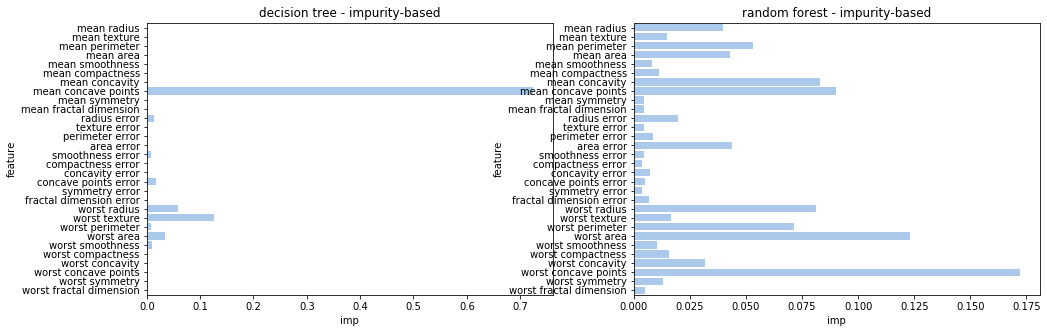

In [10]:
plt.figure(figsize = (16, 5))

sns.set_color_codes("pastel")
plt.subplot(1, 2, 1)
sns.barplot(x="imp", y="feature", data=tmodel_impurity_imp,
           color="b").set_title("decision tree - impurity-based")
plt.subplot(1, 2, 2)
sns.barplot(x="imp", y="feature", data=clf_impurity_imp,
           color="b").set_title("random forest - impurity-based")

We obtained totally different results from decision tree and random forest.

### (4.2) permutation importance

The importance (calculated from each repeats and its corresponding mean and std) is defined to be the difference between the baseline metric and metric from permutating the feature column.  
If not providing additional scoring term in the permutation_importance(), then the original metric in the fitted estimator will be used. Since we are doing binary classification, the default should be accuracy.  

This means, the permutation importance in the results are represent "how much accuracy will be affected by removing this feature".


In [11]:
tmodel_results = permutation_importance(tmodel, X_train, y_train, n_repeats = 100, random_state = 42)

In [12]:
clf_results = permutation_importance(clf, X_train, y_train, n_repeats = 100, random_state = 42)

Text(0.5, 1.0, 'random forest - permutation importance')

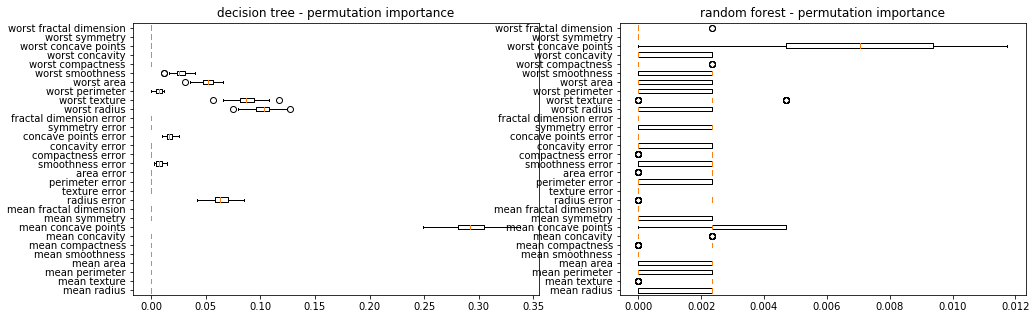

In [13]:
plt.figure(figsize = (16, 5))
plt.subplot(1, 2, 1)
plt.boxplot(tmodel_results.importances.T, vert=False,
            labels=data.feature_names)
plt.title("decision tree - permutation importance")
plt.subplot(1, 2, 2)
plt.boxplot(clf_results.importances.T, vert=False,
            labels=data.feature_names)
plt.title("random forest - permutation importance")

Based on the random forest, we see that nothing is highly importance. This is due to the multicolinearity problem

### (4.3) SHAP value

SHAP can calculate the local feature importance, that is the feature importance for each data points. Then, we can take a averaged local feature importance and get the global feature importance.

In [18]:
import shap
shap.initjs()

In [20]:
tmodel_explainer = shap.TreeExplainer(tmodel)
tmodel_shap_values = tmodel_explainer.shap_values(X_train)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


In [35]:
set(y_train)

{0, 1}

In [36]:
len(tmodel_shap_values) ##one for 0 and one for 1.

2

In [38]:
tmodel_shap_values[0].shape ##rows: samples, column: features, this is the local feature importance

(426, 30)

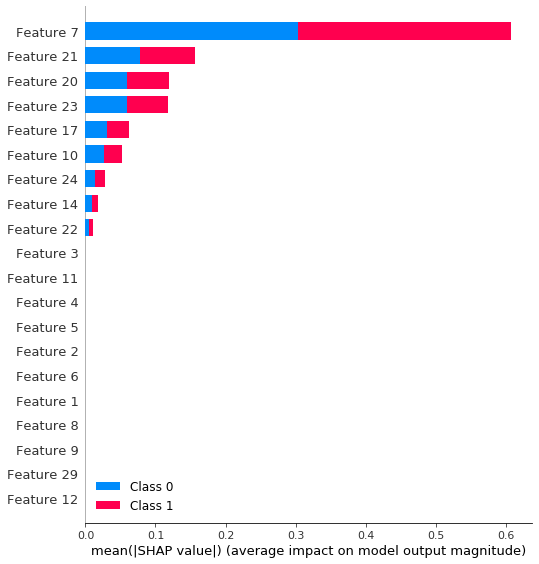

In [39]:
##aggregate local feature importance to global feature importance
shap.summary_plot(tmodel_shap_values, X_train, plot_type = "bar")

In [45]:
feature_df.iloc[[7, 21, 20, 23, 17, 10, 24, 14, 22], :]

,name,id
7,mean concave points,7
21,worst texture,21
20,worst radius,20
23,worst area,23
17,concave points error,17
10,radius error,10
24,worst smoothness,24
14,smoothness error,14
22,worst perimeter,22


In [46]:
tmodel_global_imp = np.nanmean(np.abs(np.concatenate(tmodel_shap_values)), axis = 0)

In [49]:
clf_explainer = shap.TreeExplainer(clf)
clf_shap_values = clf_explainer.shap_values(X_train)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


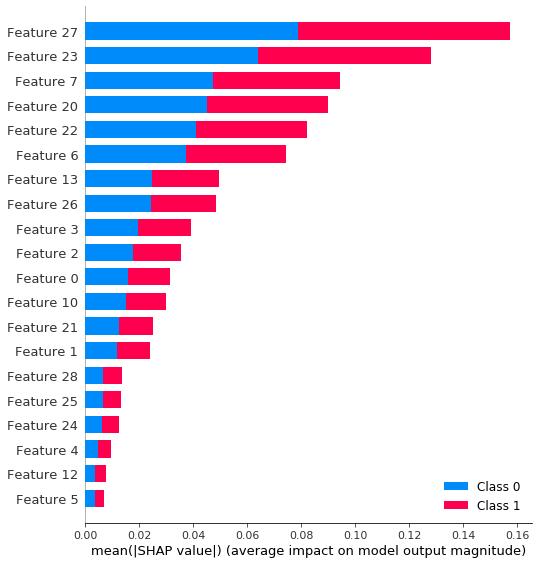

In [50]:
shap.summary_plot(clf_shap_values, X_train, plot_type = "bar")

In [59]:
clf_global_imp = np.nanmean(np.abs(np.concatenate(clf_shap_values)), axis = 0)
print(clf_global_imp.shape)

(30,)


### summarize all feature results we obtained

In [69]:
summary_imp = pd.DataFrame({
    "feature": feature_df["name"],
    "id": feature_df["id"],
    "dt_impurity": tmodel.feature_importances_,
    "rf_impurity": clf.feature_importances_,
    "dt_permutation": tmodel_results.importances_mean,
    "rf_permutation": clf_results.importances_mean,
    "dt_shap": tmodel_global_imp,
    "rf_shap": clf_global_imp
})

In [83]:
summary_imp.dtypes

feature            object
id                  int64
dt_impurity       float64
rf_impurity       float64
dt_permutation    float64
rf_permutation    float64
dt_shap           float64
rf_shap           float64
dtype: object

Text(0.5, 1.0, 'rf_shap')

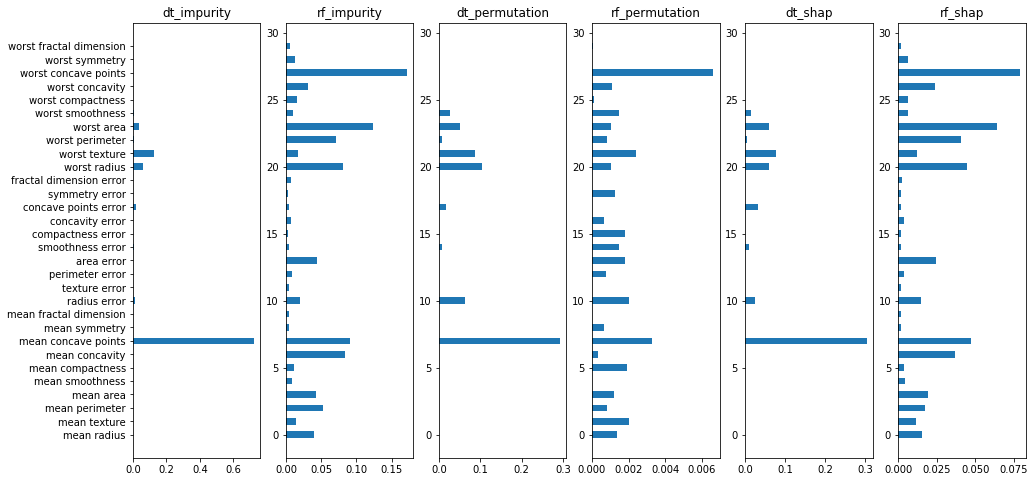

In [106]:
plt.figure(figsize = (16, 8))
plt.subplot(1, 6, 1)
plt.barh(y = summary_imp["id"], width = summary_imp["dt_impurity"], height = 0.5, tick_label = summary_imp["feature"])
plt.title("dt_impurity")
plt.subplot(1, 6, 2)
plt.barh(y = summary_imp["id"], width = summary_imp["rf_impurity"], height = 0.5)
plt.title("rf_impurity")
plt.subplot(1, 6, 3)
plt.barh(y = summary_imp["id"], width = summary_imp["dt_permutation"], height = 0.5)
plt.title("dt_permutation")
plt.subplot(1, 6, 4)
plt.barh(y = summary_imp["id"], width = summary_imp["rf_permutation"], height = 0.5)
plt.title("rf_permutation")
plt.subplot(1, 6, 5)
plt.barh(y = summary_imp["id"], width = summary_imp["dt_shap"], height = 0.5)
plt.title("dt_shap")
plt.subplot(1, 6, 6)
plt.barh(y = summary_imp["id"], width = summary_imp["rf_shap"], height = 0.5)
plt.title("rf_shap")

In [133]:
rf_impurity_top10 = set(data.feature_names[np.argsort(summary_imp["rf_impurity"])[::-1][:10]])
rf_permutation_top10 = set(data.feature_names[np.argsort(summary_imp["rf_permutation"])[::-1][:10]])
rf_shap_top10 = set(data.feature_names[np.argsort(summary_imp["rf_shap"])[::-1][:10]])

In [134]:
rf_impurity_top10.intersection(rf_permutation_top10)

{'area error', 'mean concave points', 'worst concave points'}

In [135]:
rf_impurity_top10.intersection(rf_shap_top10)

{'area error',
 'mean area',
 'mean concave points',
 'mean concavity',
 'mean perimeter',
 'worst area',
 'worst concave points',
 'worst perimeter',
 'worst radius'}

In [136]:
rf_shap_top10.intersection(rf_permutation_top10)

{'area error', 'mean concave points', 'worst concave points'}

Summary, we do observe big difference between decision tree (accu = 0.93) and random forest (0.97). Model type and architecture matters a lot.  

For random forest, we have tested using impurity-based, permutation-based, and shap-based to calculate each feature's importance. The general ranking is quite similar, however:
1. rf-shap get almost the same top10 features with rf-impurity
2. rf-permutation show big different of the top10 from the other two.

I would say, still, the multicollinearity problem may be a big problem which even SHAP cannot solve.

In [141]:

def impurity_imp(model):
    return model.feature_importances_

def permutation_imp(model, x, y):
    '''
    x and y are the training set used to build the model, not the whole data set
    '''    
    results = permutation_importance(model, x, y, n_repeats = 100, random_state = 42)
    return results.importances_mean

def shap_imp(model, x):
    '''
    x and y are the training set used to build the model, not the whole data set
    '''  
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(x)
    return np.nanmean(np.abs(np.concatenate(shap_values)), axis = 0)
    

## Use hierachical clustering on spearnman rank-order corraltion, to deal with multicolinear problem

https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance_multicollinear.html

In [1]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))
corr = spearmanr(X).correlation
corr_linkage = hierarchy.ward(corr)
dendro = hierarchy.dendrogram(corr_linkage, labels=data.feature_names, ax=ax1,
                              leaf_rotation=90)
dendro_idx = np.arange(0, len(dendro['ivl']))

ax2.imshow(corr[dendro['leaves'], :][:, dendro['leaves']])
ax2.set_xticks(dendro_idx)
ax2.set_yticks(dendro_idx)
ax2.set_xticklabels(dendro['ivl'], rotation='vertical')
ax2.set_yticklabels(dendro['ivl'])
fig.tight_layout()
plt.show()

NameError: name 'plt' is not defined

In [143]:
cluster_ids = hierarchy.fcluster(corr_linkage, 2, criterion='distance')
cluster_id_to_feature_ids = defaultdict(list)
for idx, cluster_id in enumerate(cluster_ids):
    cluster_id_to_feature_ids[cluster_id].append(idx)

(cluster_id_to_feature_ids)   

defaultdict(list,
            {6: [0, 2, 3, 20, 22, 23],
             7: [1, 21],
             2: [4, 8, 24, 28],
             5: [5, 6, 7, 25, 26, 27],
             3: [9, 19, 29],
             8: [10, 12, 13],
             1: [11, 14, 18],
             4: [15, 16, 17]})

In [144]:
selected_features = [v[0] for v in cluster_id_to_feature_ids.values()]
selected_features

[0, 1, 4, 5, 9, 10, 11, 15]

In [147]:
X_train_sel = X_train[:, selected_features]
X_test_sel = X_test[:, selected_features]

clf_sel = RandomForestClassifier(n_estimators=100, random_state=42)
clf_sel.fit(X_train_sel, y_train)
print("Accuracy on test data with features removed: {:.2f}".format(
      clf_sel.score(X_test_sel, y_test)))

Accuracy on test data with features removed: 0.96


In [151]:
##with specific selected features, compare their importance
pd.DataFrame({
    "features": data.feature_names[selected_features],
    "impurity_imp": impurity_imp(clf_sel),
    "permutation_imp": permutation_imp(clf_sel, X_train_sel, y_train),
    "shap_imp": shap_imp(clf_sel, X_train_sel)
})

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


,features,impurity_imp,permutation_imp,shap_imp
0,mean radius,0.308695,0.149883,0.162487
1,mean texture,0.127227,0.053427,0.087727
2,mean smoothness,0.081466,0.032606,0.043966
3,mean compactness,0.147467,0.042230,0.085895
4,mean fractal dimension,0.057851,0.006103,0.018146
5,radius error,0.183479,0.032629,0.089389
6,texture error,0.039833,0.003568,0.015170
7,compactness error,0.053981,0.005493,0.016162
